In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import warnings
from sklearn.metrics import confusion_matrix,  precision_score, recall_score, f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import KFold
from itertools import zip_longest

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from google.colab import drive
drive.mount('/content/drive')
#importing the dataset from Roboflow, where datasets were compiled and their annotations were converted into a unified csv file.
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="naVCsgWzrWEXZju2PWAC")
project = rf.workspace("project-4ohwz").project("combined-nf2nh")
version = project.version(1)
dataset = version.download("retinanet")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Combined-1 in retinanet:: 100%|██████████| 13722/13722 [00:01<00:00, 7064.55it/s]


In [2]:
selected_classes = {
            'Corn leaf blight',
            'Banana Fusarium Wilt',
            'Banana healthy',
            'Cherry armillaria mellea',
            'Cherry leaf healthy',
            'Corn Gray leaf spot',
            'Corn leaf healthy',
            'Corn rust leaf',
            'Peach Anarsia Lineatella',
            'Peach leaf healthy'}

In [4]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, class_limit=None):
        # Load the annnotations csv file
        self.annotations = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform

        # Since the imported annotations csv does not have labeled columns,. column names must be mnanually assigned.
        # The columns are the images name, the x and y coordinates for the bottom left corner of the bounding box and top right corner of the bounding box.
        self.annotations.columns = ['image_filename', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

        # This dictionary and function below converts the images class labels from string to numeric values for easier processing by the model .
        self.class_to_index = {
            'Corn leaf blight': 0,
            'Banana Fusarium Wilt': 1,
            'Banana healthy': 2,
            'Cherry armillaria mellea': 3,
            'Cherry leaf healthy': 4,
            'Corn Gray leaf spot': 5,
            'Corn leaf healthy': 6,
            'Corn rust leaf': 7,
            'Peach Anarsia Lineatella': 8,
            'Peach leaf healthy': 9,
        }
        self.annotations['label'] = self.annotations['label'].map(self.class_to_index)

        # This checks to see if the class labels are within the dictionary specified above.
        if self.annotations['label'].isnull().any():
            missing_labels = self.annotations[self.annotations['label'].isnull()]
            raise ValueError(f"Some labels in the dataset do not match the class_to_index mapping. "
                             f"Missing labels: {missing_labels}")
        if class_limit is not None:
            self.annotations = self.limit_samples_per_class(class_limit)
  # Data in this set is limited for certain classes, so this part of the data loader is set up to provide a limit for specified classes. This ensures that the data is more balanced by udersampling the majorty classes.
    def limit_samples_per_class(self, class_limit):
        limited_annotations = []
        for label, limit in class_limit.items():
            class_data = self.annotations[self.annotations['label'] == label]
            limited_annotations.extend(class_data.sample(n=min(limit if limit is not None else float('inf'), len(class_data))).values.tolist())
        return pd.DataFrame(limited_annotations, columns=self.annotations.columns)
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        # Provide the path to the image and load it with PIL.Image
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")

        # Fetch the mapped numbered class label and bounding box coordinates as a float value.
        label = self.annotations.iloc[idx, self.annotations.columns.get_loc('label')]
        bbox = self.annotations.iloc[idx, 1:5].values.astype(float)

        # This will apply any transformations specified to the images within the  set.
        if self.transform:
            image = self.transform(image)

        # Converts the label and bounding box coordinates to pytorch tensors.
        label = torch.tensor(label, dtype=torch.long)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return image, label, bbox


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
combined_test_dataset = CustomDataset(
    annotations_file='/content/Combined-1/test/_annotations.csv',
    img_dir='/content/Combined-1/test',
    transform=transform,
)


In [83]:
train_dataset = CustomDataset(
    annotations_file='/content/Combined-1/train/_annotations.csv',
    img_dir='/content/Combined-1/train',
    transform=transform)

In [22]:
aerial_model_path = '/content/drive/MyDrive/6399/resnet50_complete_model3_UAV.pth'
ground_model_path = '/content/drive/MyDrive/6399/resnet50_complete_model3.pth'

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

In [23]:
num_classes=10

In [82]:
# Load the pre-trained model weights
aerial_model = torch.load(aerial_model_path)
ground_model = torch.load(ground_model_path)
aerial_weights = aerial_model.state_dict()
ground_weights = ground_model.state_dict()
# Initialize a new ResNet50 model
unified_model = models.resnet50(pretrained=False)
unified_model.fc = nn.Sequential(
        nn.Linear(unified_model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
# Interpolation factor
lambda_weight = .5  # 50% contribution from both models (can be adjusted)

# Get the state dict of the unified model
unified_state_dict = unified_model.state_dict()

# Interpolate between the two sets of weights, adapting to the new FC layer structure
for key in unified_state_dict.keys():
    if 'fc.' in key:  # Only process keys related to the fully connected layer
        # Map old keys to new keys
        old_key = key.replace('fc.0', 'fc').replace('fc.3', 'fc')
        if old_key in aerial_weights and old_key in ground_weights:
            unified_state_dict[key] = (1 - lambda_weight) * aerial_weights[old_key] + lambda_weight * ground_weights[old_key]
        elif old_key in aerial_weights:
            unified_state_dict[key] = aerial_weights[old_key]
        elif old_key in ground_weights:
            unified_state_dict[key] = ground_weights[old_key]
    else:  # For other layers, directly copy weights
        if key in aerial_weights and key in ground_weights:
            unified_state_dict[key] = (1 - lambda_weight) * aerial_weights[key] + lambda_weight * ground_weights[key]
        elif key in aerial_weights:
            unified_state_dict[key] = aerial_weights[key]
        elif key in ground_weights:
            unified_state_dict[key] = ground_weights[key]

# Load the interpolated weights into the unified model
unified_model.load_state_dict(unified_state_dict)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

<All keys matched successfully>

In [84]:
test_loader = DataLoader(combined_test_dataset, batch_size=128, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

In [75]:
unified_model.eval()
dummy_input = torch.randn(1, 3, 224, 224)  # Example input
output = unified_model(dummy_input)
print(f"Unified model output shape: {output.shape}")

Unified model output shape: torch.Size([1, 10])


In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unified_model.parameters(), lr=0.0005)
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unified_model = unified_model.to(device)

# Training loop (pseudo-code)
for epoch in range(num_epochs):
    for batch in train_loader:  # Use your DataLoader
        images, labels, *_ = batch
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = unified_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Fine-tuning completed.")

Fine-tuning completed.


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unified_model.to(device)
unified_model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = unified_model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [89]:
#Preparing a confusion matrix for the predicted vs true class values.
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

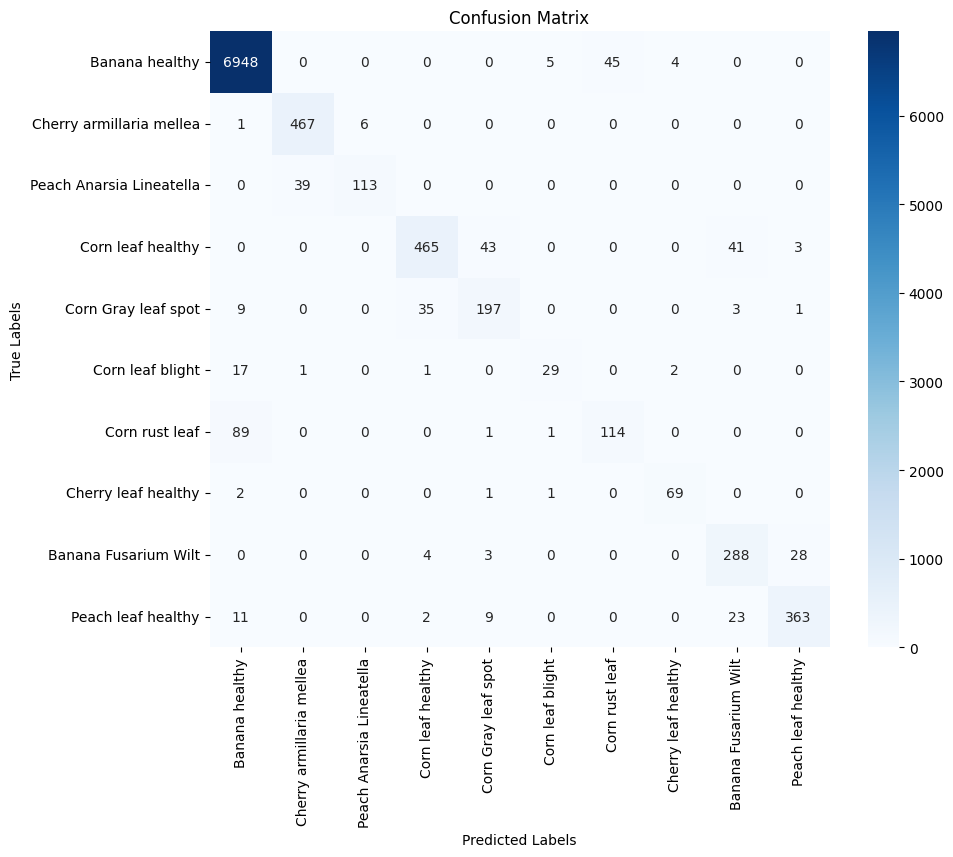

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [91]:
#Printing out precision, recall and f1 scores for each class by this model
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels,
    predicted_labels,
    labels=list(range(len(selected_classes))),
    zero_division=0
    )
for i, class_name in enumerate(selected_classes):
    print(f"{class_name}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}, F1 Score = {f1[i]:.2f}")

Banana healthy: Precision = 0.98, Recall = 0.99, F1 Score = 0.99
Cherry armillaria mellea: Precision = 0.92, Recall = 0.99, F1 Score = 0.95
Peach Anarsia Lineatella: Precision = 0.95, Recall = 0.74, F1 Score = 0.83
Corn leaf healthy: Precision = 0.92, Recall = 0.84, F1 Score = 0.88
Corn Gray leaf spot: Precision = 0.78, Recall = 0.80, F1 Score = 0.79
Corn leaf blight: Precision = 0.81, Recall = 0.58, F1 Score = 0.67
Corn rust leaf: Precision = 0.72, Recall = 0.56, F1 Score = 0.63
Cherry leaf healthy: Precision = 0.92, Recall = 0.95, F1 Score = 0.93
Banana Fusarium Wilt: Precision = 0.81, Recall = 0.89, F1 Score = 0.85
Peach leaf healthy: Precision = 0.92, Recall = 0.89, F1 Score = 0.90


In [92]:
precision_all = precision_score(true_labels, predicted_labels, average='macro')
recall_all = recall_score(true_labels, predicted_labels, average='macro')
f1_all = f1_score(true_labels, predicted_labels, average='macro')
accuracy_all = accuracy_score(true_labels, predicted_labels)

print(f"Average Precision for all classes: {precision_all:.2f}")
print(f"Average Recall for all classes: {recall_all:.2f}")
print(f"Average F1 Score for all classes: {f1_all:.2f}")
print(f"Overall Accuracy: {accuracy_all}")

Average Precision for all classes: 0.87
Average Recall for all classes: 0.82
Average F1 Score for all classes: 0.84
Overall Accuracy: 0.954555040067482
